# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_026  A0A087X1V2        14.479
Sample_001  P0C0L4            19.123
Sample_026  P10451-5          17.229
Sample_107  Q12841;Q12841-2   17.763
Sample_148  P0DOY3            24.274
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups
Sample_200  Q9H8J5           16.340
Sample_023  Q2UY09           11.847
Sample_084  A0A0B4J1V6       14.580
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.483
            A0A075B6Q5                 12.354
            A0A075B6R2                 13.113
            A0A075B6S5                 14.275
            A0A087WSY4                 13.900
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.242
            Q9UI40;Q9UI40-2            12.428
            Q9UIW2                     12.201
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.509
            Q9UP79                     13.681
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,10.944,15.050,16.842,19.863,13.283,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.738,19.067,...,15.528,15.576,12.291,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.885,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,13.604,17.705,17.039,14.748,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.908,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,12.203,15.345,17.084,18.708,14.249,19.433,10.152,6.814
Sample_207,15.739,16.877,15.469,16.898,14.775,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,11.484,13.345,13.480,12.117,12.439,13.043,14.537,12.844,12.188,12.953
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.088,19.067,16.127,...,12.731,12.866,12.855,13.670,12.767,14.427,12.611,11.822,12.106,11.829
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.262,13.899,12.041,12.756,12.999,13.876,14.187,12.823,12.805,12.472
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.059,13.948,12.193,12.657,12.999,12.534,12.903,12.956,13.087,13.448
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.046,12.287,13.885,12.692,12.039,12.556,13.354,13.633,12.598,11.656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.636,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 325.29it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.18it/s]

100%|██████████| 2/2 [00:00<00:00,  6.14it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  9.22it/s]

100%|██████████| 3/3 [00:00<00:00,  5.68it/s]

100%|██████████| 3/3 [00:00<00:00,  6.13it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.42it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.43it/s]

100%|██████████| 4/4 [00:00<00:00,  4.78it/s]

100%|██████████| 4/4 [00:00<00:00,  5.07it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.48it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.36it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.01it/s]

100%|██████████| 5/5 [00:01<00:00,  3.08it/s]

100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.55it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.59it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.75it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.78it/s]

100%|██████████| 6/6 [00:01<00:00,  3.97it/s]

100%|██████████| 6/6 [00:01<00:00,  3.91it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.48it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.84it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.16it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.96it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.45it/s]

100%|██████████| 7/7 [00:01<00:00,  4.44it/s]

100%|██████████| 7/7 [00:01<00:00,  4.86it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.75it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.98it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.15it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.97it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.62it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.51it/s]

100%|██████████| 8/8 [00:01<00:00,  4.31it/s]

100%|██████████| 8/8 [00:01<00:00,  4.79it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.40it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.09it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.17it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.93it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.78it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.48it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.58it/s]

100%|██████████| 9/9 [00:02<00:00,  3.68it/s]

100%|██████████| 9/9 [00:02<00:00,  4.47it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 10.01it/s]

 40%|████      | 4/10 [00:00<00:01,  5.88it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.31it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.09it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.41it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.87it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.58it/s]

100%|██████████| 10/10 [00:03<00:00,  2.40it/s]

100%|██████████| 10/10 [00:03<00:00,  3.22it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.74it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.04it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.61it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.82it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.52it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.11it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.83it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.61it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.63it/s]

100%|██████████| 11/11 [00:03<00:00,  2.52it/s]

100%|██████████| 11/11 [00:03<00:00,  3.12it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.93it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.81it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.47it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.10it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.70it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.56it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.56it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.69it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.84it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.04it/s]

100%|██████████| 12/12 [00:03<00:00,  3.10it/s]

100%|██████████| 12/12 [00:03<00:00,  3.09it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.82it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.36it/s]

 31%|███       | 4/13 [00:00<00:02,  4.18it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.32it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.91it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.74it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.49it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.41it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.52it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.58it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.89it/s]

100%|██████████| 13/13 [00:04<00:00,  2.93it/s]

100%|██████████| 13/13 [00:04<00:00,  3.00it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.29it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.05it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.64it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.50it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.33it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.51it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.80it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.90it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.08it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.23it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  3.18it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.11it/s]

100%|██████████| 14/14 [00:04<00:00,  3.02it/s]

100%|██████████| 14/14 [00:04<00:00,  2.91it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.47it/s]

 20%|██        | 3/15 [00:00<00:03,  3.50it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.25it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.91it/s]

 40%|████      | 6/15 [00:01<00:03,  2.71it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.57it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.69it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.92it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.81it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.88it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.11it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.31it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.27it/s]

100%|██████████| 15/15 [00:04<00:00,  3.21it/s]

100%|██████████| 15/15 [00:04<00:00,  3.07it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.046 0.020          0.850 0.243       0.143   
2             0.004 0.002      0.049 0.023          0.705 0.090       0.604   
3             0.006 0.007      0.066 0.028          0.683 0.094       0.603   
4             0.003 0.000      0.039 0.011          0.742 0.103       0.622   
5             0.003 0.000      0.038 0.009          0.726 0.083       0.677   
6             0.004 0.004      0.053 0.028          0.780 0.096       0.817   
7             0.006 0.004      0.059 0.026          0.783 0.091       0.815   
8             0.007 0.007      0.065 0.027          0.787 0.100       0.803   
9             0.006 0.005      0.068 0.029          0.803 0.088       0.815   
10            0.005 0.004      0.048 0.024          0.804 0.081       0.812   
11            0.006 0.007      0.048 0.025          0.808 0.080       0.808   
12            0.004 0.003      0.045 0.022          0.834 0.077       0.801   
13            0.005 0.004      0.045 0.020          0.830 0.082       0.808   
14            0.004 0.002      0.041 0.016          0.816 0.082       0.800   
15            0.005 0.005      0.043 0.018          0.815 0.085       0.797   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.078   0.237 0.116                  0.563 0.039        0.859   
2          0.105   0.645 0.080                  0.708 0.059        0.788   
3          0.107   0.634 0.080                  0.696 0.060        0.777   
4          0.109   0.671 0.088                  0.730 0.066        0.804   
5          0.108   0.695 0.075                  0.743 0.057        0.812   
6          0.108   0.793 0.081                  0.822 0.070        0.894   
7          0.104   0.793 0.075                  0.823 0.065        0.893   
8          0.118   0.789 0.085                  0.819 0.072        0.893   
9          0.102   0.805 0.078                  0.833 0.067        0.911   
10         0.099   0.805 0.073                  0.833 0.063        0.911   
11         0.100   0.804 0.071                  0.833 0.060        0.910   
12         0.094   0.813 0.064                  0.841 0.053        0.915   
13         0.094   0.814 0.064                  0.842 0.054        0.915   
14         0.094   0.804 0.064                  0.832 0.053        0.913   
15         0.095   0.801 0.066                  0.830 0.055        0.913   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.828 0.087        210.000 0.000  
2          0.066                  0.762 0.085        210.000 0.000  
3          0.068                  0.750 0.087        210.000 0.000  
4          0.065                  0.776 0.085        210.000 0.000  
5          0.063                  0.780 0.087        210.000 0.000  
6          0.050                  0.865 0.061        210.000 0.000  
7          0.050                  0.863 0.061        210.000 0.000  
8          0.051                  0.866 0.062        210.000 0.000  
9          0.047                  0.898 0.053        210.000 0.000  
10         0.048                  0.897 0.054        210.000 0.000  
11         0.048                  0.895 0.055        210.000 0.000  
12         0.047                  0.905 0.049        210.000 0.000  
13         0.046                  0.905 0.048        210.000 0.000  
14         0.047                  0.905 0.047        210.000 0.000  
15         0.047                  0.904 0.047 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 498.20it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.17it/s]

100%|██████████| 2/2 [00:00<00:00,  7.15it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.62it/s]

100%|██████████| 3/3 [00:00<00:00,  3.90it/s]

100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.92it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.65it/s]

100%|██████████| 4/4 [00:00<00:00,  4.81it/s]

100%|██████████| 4/4 [00:00<00:00,  5.25it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.79it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.84it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.26it/s]

100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

100%|██████████| 5/5 [00:01<00:00,  3.37it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.53it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.15it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.61it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.28it/s]

100%|██████████| 6/6 [00:01<00:00,  3.90it/s]

100%|██████████| 6/6 [00:01<00:00,  4.38it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.10it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.70it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.67it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.71it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.67it/s]

100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.66it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.42it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.61it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.56it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.55it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.72it/s]

100%|██████████| 8/8 [00:02<00:00,  3.70it/s]

100%|██████████| 8/8 [00:02<00:00,  3.81it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.91it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.90it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.22it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.62it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.51it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.44it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.52it/s]

100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

100%|██████████| 9/9 [00:03<00:00,  2.79it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.00it/s]

 30%|███       | 3/10 [00:00<00:01,  3.60it/s]

 40%|████      | 4/10 [00:01<00:01,  3.39it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.44it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.95it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.83it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.96it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.18it/s]

100%|██████████| 10/10 [00:03<00:00,  3.35it/s]

100%|██████████| 10/10 [00:03<00:00,  3.29it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.55it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.11it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.25it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.97it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.52it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  2.90it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.42it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.29it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.34it/s]

100%|██████████| 11/11 [00:03<00:00,  2.62it/s]

100%|██████████| 11/11 [00:03<00:00,  2.98it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.14it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.64it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.40it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.38it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.37it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.83it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.83it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.04it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  3.15it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.25it/s]

100%|██████████| 12/12 [00:03<00:00,  3.26it/s]

100%|██████████| 12/12 [00:03<00:00,  3.26it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.32it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.08it/s]

 31%|███       | 4/13 [00:00<00:01,  4.66it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.36it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.26it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.16it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.47it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.97it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.38it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.15it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.28it/s]

100%|██████████| 13/13 [00:04<00:00,  2.43it/s]

100%|██████████| 13/13 [00:04<00:00,  3.02it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.54it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.66it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.29it/s]

 36%|███▌      | 5/14 [00:02<00:04,  2.22it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.25it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.42it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.47it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.43it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.59it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.64it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.58it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.75it/s]

100%|██████████| 14/14 [00:05<00:00,  2.62it/s]

100%|██████████| 14/14 [00:05<00:00,  2.54it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.62it/s]

 20%|██        | 3/15 [00:00<00:03,  3.77it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.51it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.13it/s]

 40%|████      | 6/15 [00:01<00:02,  3.01it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.18it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.33it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.34it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.44it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.58it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.90it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.99it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.00it/s]

100%|██████████| 15/15 [00:04<00:00,  4.00it/s]

100%|██████████| 15/15 [00:04<00:00,  3.63it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.007      0.063 0.025          0.845 0.248       0.143   
2             0.004 0.002      0.037 0.007          0.794 0.298       0.127   
3             0.005 0.004      0.050 0.019          0.536 0.130       0.411   
4             0.006 0.006      0.063 0.030          0.655 0.103       0.609   
5             0.004 0.003      0.041 0.015          0.775 0.093       0.729   
6             0.004 0.002      0.039 0.015          0.810 0.081       0.768   
7             0.003 0.000      0.039 0.012          0.820 0.088       0.778   
8             0.004 0.002      0.038 0.014          0.823 0.082       0.782   
9             0.005 0.003      0.053 0.018          0.826 0.082       0.784   
10            0.005 0.004      0.054 0.026          0.806 0.082       0.788   
11            0.004 0.001      0.043 0.012          0.807 0.083       0.784   
12            0.006 0.005      0.051 0.021          0.806 0.080       0.808   
13            0.004 0.001      0.039 0.012          0.811 0.078       0.830   
14            0.006 0.005      0.069 0.028          0.814 0.071       0.833   
15            0.005 0.004      0.050 0.018          0.815 0.070       0.831   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.081   0.237 0.118                  0.563 0.041        0.852   
2          0.089   0.210 0.129                  0.555 0.042        0.826   
3          0.112   0.457 0.099                  0.571 0.071        0.681   
4          0.110   0.627 0.095                  0.686 0.077        0.757   
5          0.116   0.748 0.093                  0.787 0.075        0.834   
6          0.121   0.783 0.083                  0.818 0.067        0.900   
7          0.114   0.793 0.082                  0.825 0.066        0.902   
8          0.117   0.797 0.083                  0.829 0.067        0.899   
9          0.119   0.800 0.084                  0.831 0.068        0.898   
10         0.123   0.791 0.085                  0.824 0.068        0.898   
11         0.112   0.790 0.073                  0.822 0.061        0.899   
12         0.113   0.803 0.082                  0.832 0.069        0.904   
13         0.105   0.817 0.077                  0.844 0.066        0.908   
14         0.098   0.821 0.071                  0.847 0.061        0.912   
15         0.095   0.820 0.069                  0.846 0.059        0.911   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.824 0.088        210.000 0.000  
2          0.097                  0.790 0.117        210.000 0.000  
3          0.091                  0.625 0.089        210.000 0.000  
4          0.085                  0.712 0.100        210.000 0.000  
5          0.074                  0.801 0.095        210.000 0.000  
6          0.052                  0.876 0.063        210.000 0.000  
7          0.051                  0.881 0.059        210.000 0.000  
8          0.052                  0.879 0.059        210.000 0.000  
9          0.054                  0.878 0.060        210.000 0.000  
10         0.050                  0.878 0.056        210.000 0.000  
11         0.050                  0.881 0.055        210.000 0.000  
12         0.045                  0.886 0.052        210.000 0.000  
13         0.044                  0.894 0.047        210.000 0.000  
14         0.043                  0.899 0.048        210.000 0.000  
15         0.043                  0.898 0.049 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1248.30it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 30.16it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 22.18it/s]

100%|██████████| 3/3 [00:00<00:00, 21.84it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 24.57it/s]

100%|██████████| 4/4 [00:00<00:00, 19.92it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 18.22it/s]

 80%|████████  | 4/5 [00:00<00:00, 16.51it/s]

100%|██████████| 5/5 [00:00<00:00, 16.36it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 29.69it/s]

100%|██████████| 6/6 [00:00<00:00, 16.00it/s]

100%|██████████| 6/6 [00:00<00:00, 16.78it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 20.95it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 15.91it/s]

100%|██████████| 7/7 [00:00<00:00, 16.17it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 19.59it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 16.99it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 16.12it/s]

100%|██████████| 8/8 [00:00<00:00, 16.06it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 15.93it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 14.24it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 13.76it/s]

100%|██████████| 9/9 [00:00<00:00, 12.74it/s]

100%|██████████| 9/9 [00:00<00:00, 13.34it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 19.70it/s]

 50%|█████     | 5/10 [00:00<00:00, 14.27it/s]

 70%|███████   | 7/10 [00:00<00:00, 13.12it/s]

 90%|█████████ | 9/10 [00:00<00:00, 12.59it/s]

100%|██████████| 10/10 [00:00<00:00, 13.33it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 22.26it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 17.41it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 14.39it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.96it/s]

100%|██████████| 11/11 [00:00<00:00, 14.57it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 22.13it/s]

 50%|█████     | 6/12 [00:00<00:00, 18.23it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 16.89it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 16.42it/s]

100%|██████████| 12/12 [00:00<00:00, 16.64it/s]

100%|██████████| 12/12 [00:00<00:00, 16.83it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 24.15it/s]

 46%|████▌     | 6/13 [00:00<00:00, 18.67it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 17.23it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 16.34it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 13.82it/s]

100%|██████████| 13/13 [00:00<00:00, 15.60it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 22.61it/s]

 43%|████▎     | 6/14 [00:00<00:00, 17.87it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 16.78it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 16.11it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 15.85it/s]

100%|██████████| 14/14 [00:00<00:00, 15.10it/s]

100%|██████████| 14/14 [00:00<00:00, 16.13it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 21.84it/s]

 40%|████      | 6/15 [00:00<00:00, 16.30it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 14.61it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 15.01it/s]

 80%|████████  | 12/15 [00:00<00:00, 14.96it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 14.58it/s]

100%|██████████| 15/15 [00:00<00:00, 15.40it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.033 0.014          0.120 0.312       0.010   
2             0.003 0.002      0.037 0.014          0.590 0.440       0.095   
3             0.003 0.000      0.033 0.008          0.621 0.347       0.115   
4             0.005 0.004      0.049 0.017          0.514 0.358       0.104   
5             0.004 0.004      0.035 0.009          0.553 0.238       0.163   
6             0.004 0.003      0.047 0.019          0.539 0.257       0.173   
7             0.006 0.005      0.061 0.023          0.543 0.134       0.289   
8             0.009 0.009      0.059 0.022          0.534 0.134       0.288   
9             0.004 0.002      0.039 0.009          0.522 0.159       0.281   
10            0.005 0.003      0.053 0.020          0.502 0.150       0.277   
11            0.005 0.005      0.054 0.032          0.481 0.131       0.281   
12            0.006 0.005      0.061 0.023          0.461 0.156       0.265   
13            0.007 0.007      0.061 0.025          0.474 0.136       0.314   
14            0.007 0.006      0.062 0.022          0.466 0.125       0.313   
15            0.005 0.004      0.045 0.016          0.495 0.121       0.356   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.019 0.050                  0.503 0.015        0.743   
2          0.099   0.154 0.144                  0.537 0.046        0.703   
3          0.083   0.182 0.114                  0.530 0.037        0.700   
4          0.078   0.162 0.114                  0.521 0.038        0.668   
5          0.090   0.239 0.106                  0.529 0.043        0.623   
6          0.081   0.246 0.099                  0.516 0.060        0.596   
7          0.085   0.367 0.088                  0.548 0.057        0.576   
8          0.083   0.364 0.085                  0.543 0.061        0.565   
9          0.080   0.353 0.081                  0.534 0.058        0.551   
10         0.085   0.345 0.087                  0.527 0.060        0.538   
11         0.092   0.345 0.092                  0.522 0.063        0.530   
12         0.089   0.326 0.094                  0.510 0.066        0.513   
13         0.097   0.368 0.093                  0.523 0.064        0.517   
14         0.093   0.365 0.087                  0.519 0.058        0.515   
15         0.077   0.408 0.077                  0.538 0.066        0.576   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.071                  0.658 0.082        210.000 0.000  
2          0.102                  0.681 0.101        210.000 0.000  
3          0.120                  0.648 0.125        210.000 0.000  
4          0.120                  0.617 0.129        210.000 0.000  
5          0.104                  0.568 0.107        210.000 0.000  
6          0.105                  0.539 0.111        210.000 0.000  
7          0.094                  0.548 0.091        210.000 0.000  
8          0.094                  0.536 0.095        210.000 0.000  
9          0.093                  0.524 0.090        210.000 0.000  
10         0.089                  0.509 0.089        210.000 0.000  
11         0.084                  0.503 0.083        210.000 0.000  
12         0.084                  0.491 0.083        210.000 0.000  
13         0.082                  0.494 0.073        210.000 0.000  
14         0.082                  0.487 0.076        210.000 0.000  
15         0.080                  0.522 0.085 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,8,1,8
score_time,9,14,14
test_precision,1,1,3
test_recall,6,14,15
test_f1,13,14,15
test_balanced_accuracy,13,14,7
test_roc_auc,13,14,1
test_average_precision,12,14,2
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.61it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.40it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.03it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.53it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.51it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.53it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.14it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.95it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.88it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.76it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.73it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.77it/s]

100%|██████████| 14/14 [00:04<00:00,  2.83it/s]

100%|██████████| 14/14 [00:04<00:00,  3.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1053.58it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.25it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.77it/s]

 31%|███       | 4/13 [00:00<00:01,  4.76it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.37it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.22it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.86it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.54it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.26it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.34it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.26it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.07it/s]

100%|██████████| 13/13 [00:03<00:00,  3.02it/s]

100%|██████████| 13/13 [00:03<00:00,  3.60it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


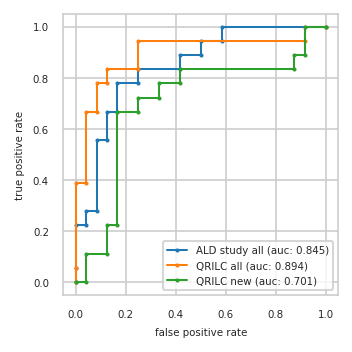

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.042 0.000
2          0.000 0.222     0.000 0.389     0.042 0.111
3          0.042 0.222     0.042 0.389     0.125 0.111
4          0.042 0.278     0.042 0.667     0.125 0.222
5          0.083 0.278     0.083 0.667     0.167 0.222
6          0.083 0.556     0.083 0.778     0.167 0.667
7          0.125 0.556     0.125 0.778     0.250 0.667
8          0.125 0.667     0.125 0.833     0.250 0.722
9          0.167 0.667     0.250 0.833     0.333 0.722
10         0.167 0.778     0.250 0.944     0.333 0.778
11         0.250 0.778     0.917 0.944     0.417 0.778
12         0.250 0.833     0.917 1.000     0.417 0.833
13         0.417 0.833     1.000 1.000     0.875 0.833
14         0.417 0.889       NaN   NaN     0.875 0.889
15         0.500 0.889       NaN   NaN     0.917 0.889
16         0.500 0.944       NaN   NaN     0.917 1.000
17         0.583 0.944       NaN   NaN     1.000 1.000
18         0.583 1.000       NaN   NaN       NaN   NaN
19         1.000 1.000       NaN   NaN       NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
1,Q9NR34,O95428;O95428-5;O95428-6,None
2,P00740;P00740-2,P15151-2,None
3,Q13231;Q13231-3,P14174,None
4,P04075,P61981,None
5,P61981,Q9Y2T3;Q9Y2T3-3,None
6,C9JF17;P05090,P04075,None
7,P14174,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3,None
8,Q9Y2T3;Q9Y2T3-3,A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;...,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


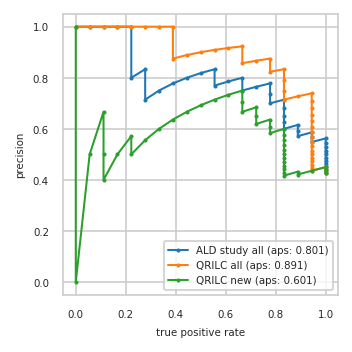

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.436 0.944     0.436 0.944
4          0.474 1.000     0.447 0.944     0.421 0.889
5          0.486 1.000     0.459 0.944     0.432 0.889
6          0.500 1.000     0.472 0.944     0.417 0.833
7          0.514 1.000     0.486 0.944     0.429 0.833
8          0.529 1.000     0.500 0.944     0.441 0.833
9          0.545 1.000     0.515 0.944     0.455 0.833
10         0.562 1.000     0.531 0.944     0.469 0.833
11         0.548 0.944     0.548 0.944     0.484 0.833
12         0.567 0.944     0.567 0.944     0.500 0.833
13         0.586 0.944     0.586 0.944     0.517 0.833
14         0.571 0.889     0.607 0.944     0.536 0.833
15         0.593 0.889     0.630 0.944     0.556 0.833
16         0.615 0.889     0.654 0.944     0.577 0.833
17         0.600 0.833     0.680 0.944     0.600 0.833
18         0.625 0.833     0.708 0.944     0.583 0.778
19         0.652 0.833     0.739 0.944     0.609 0.778
20         0.682 0.833     0.727 0.889     0.636 0.778
21         0.714 0.833     0.714 0.833     0.619 0.722
22         0.700 0.778     0.750 0.833     0.650 0.722
23         0.737 0.778     0.789 0.833     0.684 0.722
24         0.778 0.778     0.833 0.833     0.667 0.667
25         0.765 0.722     0.824 0.778     0.706 0.667
26         0.750 0.667     0.875 0.778     0.750 0.667
27         0.800 0.667     0.867 0.722     0.733 0.611
28         0.786 0.611     0.857 0.667     0.714 0.556
29         0.769 0.556     0.923 0.667     0.692 0.500
30         0.833 0.556     0.917 0.611     0.667 0.444
31         0.818 0.500     0.909 0.556     0.636 0.389
32         0.800 0.444     0.900 0.500     0.600 0.333
33         0.778 0.389     0.889 0.444     0.556 0.278
34         0.750 0.333     0.875 0.389     0.500 0.222
35         0.714 0.278     1.000 0.389     0.571 0.222
36         0.833 0.278     1.000 0.333     0.500 0.167
37         0.800 0.222     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


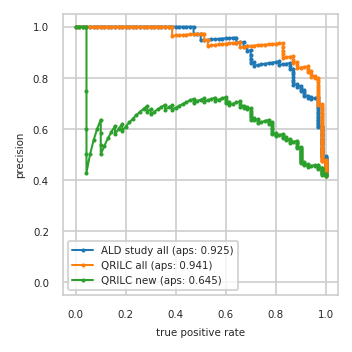

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


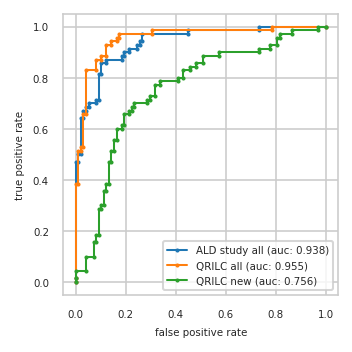

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}